## Finding specific variants in each cluster
Using the clones, we want to find variants in each clone that are specific to them.
To define specificity, we will use two parameters: VAF frequency cutoff, and different %of population to have that variant.
These parameters will be used to compare each clone's variants to the population

In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_vars'

In [2]:
INDIR = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/concat/"
OUTDIR = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/concat/distinct_variants/donor0"
DONOR = 0

In [3]:
pct_thresh = [0.01, 0.5, 0.75, 0.95]
other_pct_thresh = [0.01, 0.1, 0.25,]
af_thresh = [0, 0.01, 0.1, 0.4]

In [4]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from mplh import cluster_help as ch
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


In [5]:
if not exists(OUTDIR):
    os.mkdir(OUTDIR)

## Load cluster results

In [6]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

print(AF_df.shape)
print(DP_df.shape)
print("Depth")
print(DP_df.head())
AF_df.head()

(68, 9023)
(68, 9023)
Depth
         AAACGAAAGAATCAAC-1_Control  AAACGAAAGCGAGAAA-1_Control  \
Variant                                                           
10397G                          2.0                        16.0   
10463C                         11.0                        16.0   
10559G                         15.0                        26.0   
10589A                         17.0                        21.0   
11251G                         13.0                        25.0   

         AAACGAAAGTACAGAT-1_Control  AAACGAAAGTTAGCAA-1_Control  \
Variant                                                           
10397G                          1.0                         5.0   
10463C                          3.0                         9.0   
10559G                          5.0                         5.0   
10589A                          6.0                         7.0   
11251G                          5.0                         7.0   

         AAACGAACACTCGCAG-1_Cont

,AAACGAAAGAATCAAC-1_Control,AAACGAAAGCGAGAAA-1_Control,AAACGAAAGTACAGAT-1_Control,AAACGAAAGTTAGCAA-1_Control,AAACGAACACTCGCAG-1_Control,AAACGAATCAGGCGCT-1_Control,AAACGAATCCATCGAA-1_Control,AAACGAATCTCGTAGA-1_Control,AAACTCGAGTGAAGGA-1_Control,AAACTCGCATGCACTA-1_Control,...,TTTGGTTTCTGATCCC-1_Input,TTTGTGTAGTTCGTTG-1_Input,TTTGTGTCACACATTG-1_Input,TTTGTGTGTAAGCCGA-1_Input,TTTGTGTGTAGATTAG-1_Input,TTTGTGTGTAGGGTCA-1_Input,TTTGTGTGTTTCTTAC-1_Input,TTTGTGTTCCTGAAAC-1_Input,TTTGTGTTCGGGAAAC-1_Input,TTTGTGTTCTGGCACG-1_Input
Variant,,,,,,,,,,,,,,,,,,,,,
10397G,1.000000,1.0,0.0,0.8,1.0,1.0,1.0,1.0,1.000000,1.0,...,0.979798,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.978495,1.0,1.000000
10463C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
10559G,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.062500,0.000000,0.000000,0.0,0.000000,0.0,0.000000
10589A,0.882353,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,...,1.000000,0.984848,1.0,0.970588,0.736842,0.966102,1.0,1.000000,1.0,1.000000
11251G,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.000000,0.036145,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.023256


In [7]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]
curr_labels

,lineage,donor,condition,name
ID,,,,
AAACGAAAGAATCAAC-1_Control,0,0,Control,0_0
AAATGAGAGAGACTCG-1_Control,0,0,Control,0_0
AACAAAGTCAAGTTGC-1_Control,0,0,Control,0_0
AACAAAGTCACATCCC-1_Control,0,0,Control,0_0
AACCAACGTTCATTTC-1_Control,0,0,Control,0_0
...,...,...,...,...
TGATCAGAGAGCACTG-1_Input,33,0,Input,0_33
TGCACCTCAAGCAATA-1_Input,33,0,Input,0_33
TGCTATTTCGCGTTCT-1_Input,33,0,Input,0_33


In [8]:
conditions = curr_labels["condition"].unique()
conditions

array(['Control', 'Flt3l', 'Input'], dtype=object)

In [9]:
def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds

In [10]:
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]
donor_inds

Index(['10397G', '10589A', '11761T', '13188T', '1438G', '146C', '14766T',
       '15326G', '16126C', '16355T', '16362C', '196C', '204C', '2442C', '263G',
       '2706G', '3847C', '4769G', '58C', '64T', '7028T', '73G', '750G',
       '7598A', '827G', '8292A', '8461T', '8860G'],
      dtype='object', name='Variant')

In [11]:
# median_af = curr_labels.groupby(["lineage", "condition"]).apply(calc_median, af=AF_df)
# anno = median_af.reset_index()[["lineage", "condition"]]

# #median_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_median, af=nlog2(DP_df))
# median_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_median, af=np.log2(DP_df+1))
# anno_dp = median_dp.reset_index()[["lineage", "condition"]]
# median_dp = median_dp.reset_index(drop=True)

# na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
# na_median_af = na_cells.groupby("condition").apply(calc_median, af=AF_df)

# if not (na_median_af.shape[0] == 0):
#     print('na shape', na_median_af.shape)
#     na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_median_af.index), "condition":na_median_af.index})), 
#                         ignore_index=True)
#     na_concat = pd.concat((median_af.reset_index(drop=True), na_median_af.reset_index(drop=True)), ignore_index=True)
#     na_median_dp = na_cells.groupby("condition").apply(calc_median, af=np.log2(DP_df+1))
#     na_dp_concat = pd.concat((median_dp, na_median_dp.reset_index(drop=True)), ignore_index=True)
# else:
#     na_anno = anno
#     na_concat = median_af.reset_index(drop=True)
#     na_dp_concat = median_dp
     
  

## Plot all cells in each clone

In [12]:
from icecream import ic

In [13]:
def get_unique_variants(cln_af, other_af, pct_thresh, af_thresh, other_pct_thresh):
    n_thresh = pct_thresh*cln_af.shape[1]
    n_oth_thresh = other_pct_thresh*other_af.shape[1]
    #ic(n_thresh)
    #ic(n_oth_thresh)
    bin_cln = cln_af>af_thresh
    bin_other = other_af>af_thresh
    #ic(bin_cln.head())
    cells_above = bin_cln.sum(axis=1)
    pct_cells_above = cells_above/cells_above.shape[0]
    #ic(cells_above.head())
    up_vars = bin_cln.loc[cells_above > n_thresh].index
    #ic(up_vars)
    cells_other_above = bin_other.sum(axis=1)
    pct_cells_other_above =  cells_other_above/cells_other_above.shape[0]
    up_oth_vars = bin_other.loc[cells_other_above > n_oth_thresh].index
    uniq_vars = list(set(up_vars) - set(up_oth_vars))
    #ic(uniq_vars)
    #ic(cells_above.loc[uniq_vars])
    #ic(list(cells_above.loc[uniq_vars].values))
    out = pd.DataFrame(index=uniq_vars, data={"n_cells":cells_above.loc[uniq_vars].values, 
                                              "n_other_cells": cells_other_above.loc[uniq_vars].values,
                                              "pct_above": pct_cells_above,
                                              "pct_other_above": pct_cells_other_above})
    out["pct_thresh"] = pct_thresh
    out["af_thresh"] = af_thresh
    out["other_pct_thresh"] = other_pct_thresh
    return out

In [14]:
all_unique_df = []
for cln, val in curr_labels.groupby("name"):
    print(cln)
    cln_af = AF_df.loc[:, val.index]
    other_af = AF_df.loc[:, curr_labels.drop(val.index).index]
    curr_dp = DP_df.loc[:, val.index]
    curr_labs = curr_labels[curr_labels.index.isin(cln_af.columns)]
    print(cln_af.shape)
    #curr_anno = pd.DataFrame(curr_af.apply(lambda x: x.name.split("_")[-1], axis=0)).rename({0:"condition"},axis=1)
    for pct_thr in pct_thresh:
        for af_thr in af_thresh:
            for other_pct_thr in other_pct_thresh:
                unique_df = get_unique_variants(cln_af, other_af, pct_thr, af_thr, other_pct_thr)
                unique_df["clone"] = cln
                unique_df["id"] = unique_df["clone"] + "_" + unique_df["pct_thresh"].astype(str)+ "_" + unique_df["af_thresh"].astype(str)+ "_" + unique_df["other_pct_thresh"].astype(str)
                unique_df["variant"] = unique_df.index
                unique_df = unique_df.set_index("id")
                all_unique_df.append(unique_df)

0_0
(68, 957)
0_1
(68, 624)
0_10
(68, 326)
0_11
(68, 318)
0_12
(68, 318)
0_13
(68, 266)
0_14
(68, 250)
0_15
(68, 232)
0_16
(68, 230)
0_17
(68, 214)
0_18
(68, 210)
0_19
(68, 197)
0_2
(68, 545)
0_20
(68, 177)
0_21
(68, 163)
0_22
(68, 154)
0_23
(68, 154)
0_24
(68, 146)
0_25
(68, 130)
0_26
(68, 127)
0_27
(68, 122)
0_28
(68, 122)
0_29
(68, 114)
0_3
(68, 429)
0_30
(68, 104)
0_31
(68, 102)
0_32
(68, 100)
0_33
(68, 71)
0_4
(68, 364)
0_5
(68, 362)
0_6
(68, 362)
0_7
(68, 353)
0_8
(68, 342)
0_9
(68, 338)


In [15]:
all_df = pd.concat(all_unique_df)

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Variants in a clone')

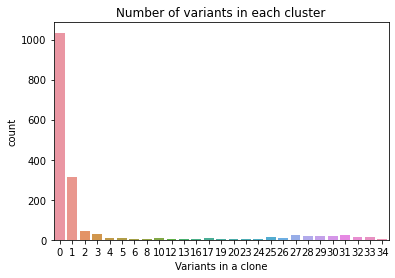

In [16]:
import seaborn as sns
sns.countplot([x.shape[0] for x in all_unique_df])
plt.title("Number of variants in each cluster")
plt.xlabel("Variants in a clone")

In [17]:
all_var_counts = {}
for ind, curr_df in all_df.groupby(["pct_thresh", "af_thresh", "other_pct_thresh"]):
    curr_var_counts = curr_df.groupby("variant").size()
    all_var_counts[("pct_thresh", "af_thresh", "other_pct_thresh")] = curr_var_counts
    f=plt.figure()
    sns.countplot(x=curr_df["variant"])
    plt.title(ind)
    plt.xticks(rotation=90)
    plt.ylabel("Number of clones variant is seen in")
    plt.savefig(join(OUTDIR, f"pct_thresh_{ind[0]}_af_thresh_{ind[1]}_other_pct_thresh_{ind[2]}__num_clones_per_var.png"))
    
    f=plt.figure()
    sns.countplot(x=curr_df.groupby("clone").size())
    plt.title("Number of variants in each cluster")
    plt.xlabel("Variants in a clone")
    plt.ylabel("Number of clones")
    plt.savefig(join(OUTDIR, f"pct_thresh_{ind[0]}_af_thresh_{ind[1]}_other_pct_thresh_{ind[2]}__num_vars_in_clone.png"))
    plt.close('all')

In [18]:
curr_var_counts = curr_df.groupby("variant").size()
curr_var_counts

variant
11453A    1
152C      1
1949A     1
dtype: int64

## Get dict of variants and how many clones its in

In [19]:
# for pct_thr in pct_thresh:
#     for af_thr in af_thresh:
#         for other_pct_thr in other_pct_thresh:
            